In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Run the following before any XLA modules such as JAX:
import chex

chex.set_n_cpu_devices(2)

# Import the remaining JAX related 
from gabenet.mcmc import sample_markov_chain
from gabenet.nets import PoissonGammaBelieve
from gabenet.utils import freeze_trainable_states

import haiku as hk
import jax
from jax import random
import jax.numpy as jnp

2023-05-03 11:04:19.175364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


To illustrate how to use a [Bayesian Poisson Gamma believe network](https://www.jmlr.org/papers/volume17/15-633/15-633.pdf), we will train the
model on the MNIST dataset, containing handwritten digits.

The dataset can directly be loaded from scikit-learn. As preprocessing step, we reshape the
digits from a 8x8 square matrix to a flat array of size 64.

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

Next, we define the model. We use a simple decoder networks with two hidden layers. In
total, the size of the network: 2 x 10 x 64.

In [3]:
# Pseudo-random number generator sequence.
key_seq = hk.PRNGSequence(42)

m_samples, n_features = X_train.shape

def build_gamma_belief_net(is_training: bool = True):
    """A two-layer decoder network."""
    n_hidden_units = (2, 10)
    return PoissonGammaBelieve(n_hidden_units, n_features, is_training=is_training)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Since the Poisson gamma believe network is a Bayesian model, we don't train the model by
minimising a loss. Rather, we estimate the distribution of the parameters. To do this,
we make use of Markov chain Monte Carlo simulations. This method samples the distributions by iteratively updating the parameters based on the current state of the model (i.e., the current parameter configuration).
We require two ingredients:
1. A way to propose a new state of the chain.  
  This is called a _kernel_, which takes the
  current state of the chain, and advances it by a single step.


In [4]:
@hk.transform_with_state
def kernel(x_images, is_training: bool = True):
    """Advances the Markov chain by one step."""
    model = build_gamma_belief_net(is_training)
    model(x_images)

2. A starting point for the chain.  
  For simplicity, we choose to take samples from
  the prior distribution (which is called a forward, or ancestral, sample). 


In [5]:
@hk.transform_with_state
def forward():
    """Initialise Markov chain using forward samples."""
    model = build_gamma_belief_net()
    return model.forward(m_samples)

n_chains = 2
key_per_chain = random.split(next(key_seq), num=n_chains)
param_init, state_init = jax.vmap(forward.init)(key_per_chain)

Finally, we draw samples from the Markov chain. We first take 100 burn-in steps, in the
hope that the chain converges to the true distribution. Thereafter, we collect a total
of 100 samples to estimate the posterior distribution (we don't perform thinning, as
indicated by a leap size of 1).

Note that `sample_markov_chain` (below) automatically takes care of distributing your
computation across multiple devices. For simplicity, we assume you are running on a CPU and split the CPU up in two virtual devices. (See above, at the import section, where we've used
`chex` set the number of devices to 2.)

The following cell, that collects statistics from the Markov chain takes, about `5 minutes` to run on a CPU.

In [6]:
states = sample_markov_chain(
    next(key_seq), 
    n_samples=100, 
    kernel_fn=lambda p, s, k: kernel.apply(p, s, k, X_train), 
    initial_params=param_init, 
    initial_state=state_init,
    n_burnin_steps=100, 
)

states['poisson_gamma_believe/~/poisson_layer']['phi'].block_until_ready()

Array([[[[2.80907389e-05, 2.76359962e-03, 3.04688998e-02, ...,
          4.06194441e-02, 3.01569211e-03, 1.74298155e-04],
         [1.91667459e-05, 1.76940739e-05, 1.13464501e-02, ...,
          1.73900425e-02, 4.77258473e-05, 9.93191043e-06],
         [3.03284687e-05, 1.67172076e-03, 2.36304589e-02, ...,
          9.00842845e-02, 6.14793822e-02, 1.25695299e-02],
         ...,
         [1.36648259e-05, 1.70367184e-05, 5.16430327e-06, ...,
          1.46524966e-04, 1.62478773e-06, 4.91802439e-06],
         [2.72714697e-05, 3.00337723e-03, 3.67496088e-02, ...,
          6.17758124e-05, 1.23517211e-05, 2.83273657e-05],
         [2.32097082e-05, 6.23488377e-05, 1.73371358e-04, ...,
          7.92139396e-02, 7.60189816e-03, 7.77930763e-05]],

        [[2.52632781e-05, 3.25687299e-03, 3.23162191e-02, ...,
          3.95572558e-02, 3.15804407e-03, 3.56680648e-05],
         [3.33859788e-07, 1.33809017e-05, 1.17578758e-02, ...,
          1.67537797e-02, 4.39682626e-05, 8.25356801e-06],
        

{'poisson_gamma_believe/~/cap_layer': {'c': Array([[2.5869362 , 0.79628867, 0.41232693, ..., 1.0807037 , 1.191857  ,
          1.6817242 ],
         [1.5586613 , 0.92558295, 1.3199984 , ..., 2.343588  , 0.39012203,
          0.6056357 ]], dtype=float32),
  'r': Array([[0.5464805 , 1.1518991 ],
         [0.99602264, 1.0823267 ]], dtype=float32),
  'theta': Array([[[6.7614448e-01, 3.5513610e-02],
          [7.3514140e-01, 3.9815626e-01],
          [1.8599153e+00, 1.7255877e+00],
          ...,
          [2.2104817e-02, 9.7663015e-01],
          [1.1192635e+00, 1.4433496e+00],
          [9.0797407e-08, 6.0732377e-01]],
  
         [[6.3506353e-01, 2.8875756e-01],
          [3.4734493e-01, 1.3984741e-01],
          [1.4624686e+00, 6.4823709e-02],
          ...,
          [2.9405698e-01, 2.2792327e+00],
          [3.8036811e-01, 2.5151787e+00],
          [7.8049111e-01, 2.9605213e-01]]], dtype=float32)},
 'poisson_gamma_believe/~/gamma_layer': {'c': Array([[0.0125881 , 0.01223243, 0.0070048

In [14]:
last_state = jax.tree_util.tree_map(lambda x: x[:, -1, ...], states)

In [17]:
last_state['poisson_gamma_believe/~/cap_layer']['c'].shape

(2, 1437)

In [ ]:

@hk.transform_with_state
def kernel_bk(x_images, is_training: bool = True):
    """Advances the Markov chain by one step."""
    # jax.debug.breakpoint()  # bt multinomial.py:170
    model = build_gamma_belief_net(is_training)
    model(x_images)

kernel_bk.apply(param_init, last_state, next(key_seq), X_train)

After training the model, we can inspect what the model has learned. Note that, instead of a single point estimate of the parameters, we've obtained a distribution. To visualise the parameters, we take for simplicity the median. Let's take a look at $\bm{\Phi}^{(1)}$, the weights of the first layer.

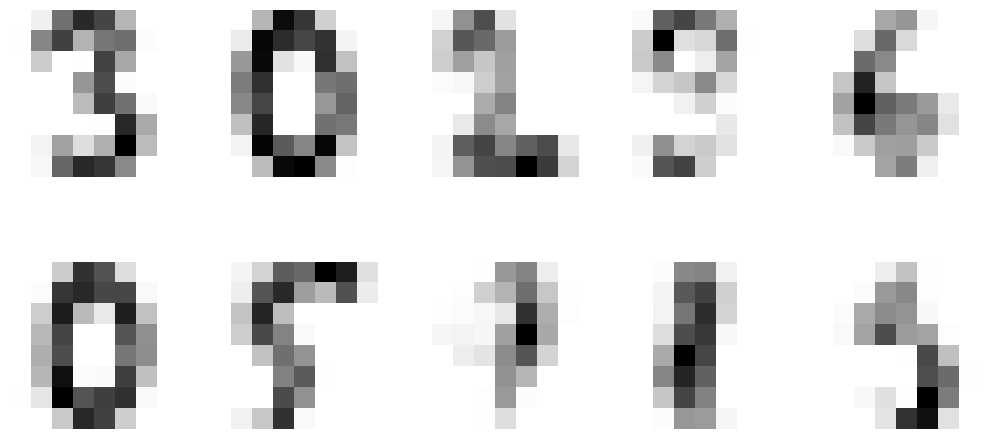

In [16]:
# Aggregate posterior samples to visualise.
phi_1st_layer = np.median(states['poisson_gamma_believe/~/poisson_layer']['phi'][0], axis=0)

# Make a plot of each latent state.
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(12.5, 6))
for ax, phi in zip(axes.flatten(), phi_1st_layer):
    ax.set_axis_off()
    image = phi.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

In [17]:
@hk.transform_with_state
def forward():
    """Initialise Markov chain using forward samples."""
    model = build_gamma_belief_net(is_training=False)
    return model.forward(len(X_test))

n_chains = 2
key_per_chain = random.split(next(key_seq), num=n_chains)
_, state_init = jax.vmap(forward.init)(key_per_chain)

In [21]:
states.keys()

dict_keys(['poisson_gamma_believe/~/cap_layer', 'poisson_gamma_believe/~/gamma_layer', 'poisson_gamma_believe/~/poisson_layer'])

In [30]:
from copy import deepcopy


def freeze_trainable_states(train_states) -> tuple[dict, dict]:
    """Lift out "training-mode" states to `params`.

    Args:
        train_states: States (pytree) of a model during training
            mode (i.e., `is_training=True`).

    Returns:
        A haiku-compatible params, states pair with the frozen states moved to params.
    """
    states = deepcopy(train_states)
    params: dict = {}
    for layer_name, layer_params in states.items():
        if layer_name not in params:
            params[layer_name] = {}
        if "poisson_layer" in layer_name:
            params[layer_name]["phi"] = layer_params.pop("phi")
        elif "cap_layer" in layer_name:
            params[layer_name]["r"] = layer_params.pop("r")
        elif "gamma_layer" in layer_name:
            params[layer_name]["phi"] = layer_params.pop("phi")
        else:
            raise KeyError(f"Unknown layer {layer_name}.")
    return params, states

params, _ = freeze_trainable_states(states)

In [61]:
# Remove middle part of the image.
X_test_corrupted = X_test.copy().reshape(-1, 8, 8)
X_test_corrupted[:, 2:-2, 2:-2] = np.nan
X_test_corrupted = X_test_corrupted.reshape(-1, 64)

/tmp/ipykernel_26550/17224088.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray_r").copy()
  cm.set_bad(color='red')


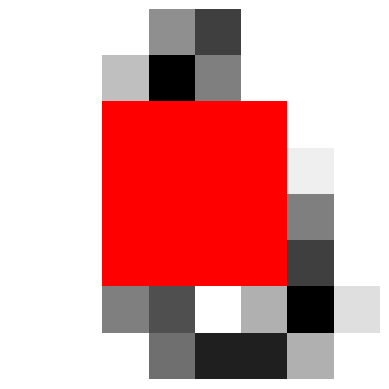

In [62]:
plt.figure()
ax = plt.gca()
ax.set_axis_off()

image = X_test_corrupted[0].reshape(8, 8).copy()
cm = plt.cm.gray_r
cm.set_bad(color='red')
# Make nan values in image red in the image.
ax.imshow(image, cmap=cm, interpolation="nearest")
# plt.show()

In [63]:
states_test = sample_markov_chain(
    next(key_seq), 
    n_samples=100, 
    kernel_fn=lambda p, s, k: kernel.apply(p, s, k, X_test_corrupted, is_training=False), 
    initial_params=jax.tree_util.tree_map(lambda x: jnp.median(x, axis=1), params), 
    initial_state=state_init,
    n_burnin_steps=100, 
)
states_test['poisson_gamma_believe/~/gamma_layer']['theta'].block_until_ready()

Array([[[[6.66731226e-20, 2.62973747e+01, 6.08779678e+01, ...,
          6.12426163e-07, 3.25060937e-05, 4.67467804e+01],
         [3.30277138e+01, 7.26992569e+01, 8.67391750e-03, ...,
          4.76660699e-01, 1.54927564e+00, 1.06838025e-01],
         [4.02566516e-13, 0.00000000e+00, 4.08988045e-29, ...,
          1.06385232e-06, 2.45471984e-01, 6.19982567e+01],
         ...,
         [2.76740196e-25, 6.32162687e-37, 3.42741089e+01, ...,
          4.33274422e+01, 9.64155138e-01, 8.47511832e-03],
         [4.85434004e-09, 1.22251682e-01, 7.36332779e+01, ...,
          7.93575076e-04, 1.56391468e-02, 5.43722076e+01],
         [3.21690470e-01, 3.80134940e+00, 2.34252415e+01, ...,
          3.05088222e-01, 7.47026539e+00, 3.18882942e+01]],

        [[1.25934874e-10, 2.62555408e+01, 8.89940414e+01, ...,
          2.29292527e-01, 6.12075164e-05, 4.90834961e+01],
         [2.67156277e+01, 7.64281540e+01, 9.37254881e-05, ...,
          3.38999867e-01, 2.38335705e+00, 7.33638406e-02],
        

In [69]:
phi_0 = jnp.median(params['poisson_gamma_believe/~/poisson_layer']['phi'][0], axis=0)
theta_0 = states_test['poisson_gamma_believe/~/poisson_layer']['theta'][0][-1]
activation = theta_0 @ phi_0

x_samples = random.poisson(
    next(key_seq),
    lam=activation,
)
x_test_repaired = jnp.where(jnp.isnan(X_test_corrupted), x_samples, X_test_corrupted)

In [73]:
theta_0[0]

Array([3.0176903e-10, 5.3203359e+00, 7.3633377e+01, 5.1456695e-06,
       3.3883590e-02, 8.7663331e-08, 0.0000000e+00, 8.8645415e-08,
       1.6838937e-08, 6.1938873e+01], dtype=float32)

/tmp/ipykernel_26550/953127871.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray_r").copy()
  cm.set_bad(color='red')


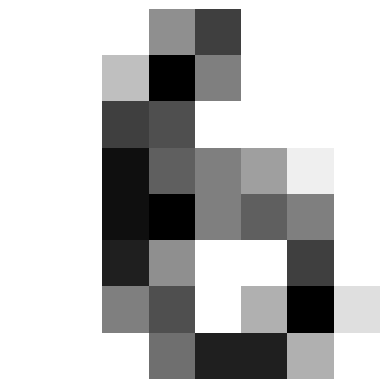

In [72]:
plt.figure()
ax = plt.gca()
ax.set_axis_off()

image = X_test[0].reshape(8, 8).copy()
cm = plt.cm.gray_r
cm.set_bad(color='red')
# Make nan values in image red in the image.
ax.imshow(image, cmap=cm, interpolation="nearest")

/tmp/ipykernel_26550/536133478.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray_r").copy()
  cm.set_bad(color='red')


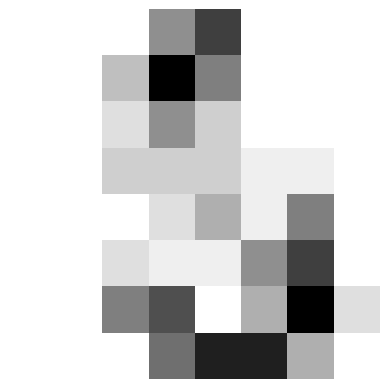

In [71]:
plt.figure()
ax = plt.gca()
ax.set_axis_off()

image = x_test_repaired[0].reshape(8, 8).copy()
cm = plt.cm.gray_r
cm.set_bad(color='red')
# Make nan values in image red in the image.
ax.imshow(image, cmap=cm, interpolation="nearest")

In [36]:
states_test['poisson_gamma_believe/~/gamma_layer']['theta'].block_until_ready()

Array([[[[4.82167491e-15, 2.43965149e+00, 2.99000587e+01, ...,
          1.58550406e+00, 1.67264118e+01, 9.47134705e+01],
         [1.11939071e-03, 4.56408277e-04, 8.33971572e-11, ...,
          6.25919304e+01, 3.66848793e+01, 7.49176712e+01],
         [2.41431778e+02, 7.12841302e-06, 4.10233370e-05, ...,
          4.25925589e+00, 1.55912316e-09, 9.55110455e+00],
         ...,
         [1.38687029e-01, 3.76101695e-02, 2.23031731e+01, ...,
          8.30566864e+01, 5.89375687e+01, 9.27197838e+00],
         [9.83864212e+01, 1.20327581e-35, 1.39809313e+01, ...,
          5.15623624e-03, 2.15269303e+00, 1.14964005e+02],
         [1.06963043e-32, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 2.71658056e-08, 1.72025833e+02]],

        [[5.07170967e-07, 1.67394012e-01, 3.83171844e+01, ...,
          1.57136989e+00, 3.10196152e+01, 1.03813812e+02],
         [3.61401290e-02, 2.04501600e-16, 1.17869580e+00, ...,
          5.85561485e+01, 3.24061127e+01, 5.95811386e+01],
        

In [27]:
p.keys()

dict_keys(['poisson_gamma_believe/~/cap_layer', 'poisson_gamma_believe/~/gamma_layer', 'poisson_gamma_believe/~/poisson_layer'])

In [29]:
p['poisson_gamma_believe/~/poisson_layer']

{'phi': Array([[[[1.04586477e-04, 3.49622942e-03, 4.11732830e-02, ...,
           3.21650654e-02, 6.41739680e-05, 3.95225798e-05],
          [4.46719532e-05, 4.64068216e-06, 1.22723579e-02, ...,
           1.94365438e-02, 5.65725146e-04, 2.22808318e-04],
          [3.15276156e-06, 3.13223898e-03, 3.36524323e-02, ...,
           7.09115788e-02, 5.45314476e-02, 1.43474676e-02],
          ...,
          [1.15683833e-05, 3.53925816e-06, 7.37416849e-05, ...,
           1.21860823e-04, 1.81352993e-06, 8.22503625e-06],
          [1.14951345e-05, 3.30677722e-06, 1.85419933e-03, ...,
           2.44304934e-03, 8.78365245e-06, 9.90222543e-06],
          [8.25812549e-06, 1.43993211e-05, 1.60794516e-05, ...,
           8.90700743e-02, 1.18532730e-02, 1.46121356e-05]],
 
         [[4.90418415e-06, 4.44191461e-03, 3.98016907e-02, ...,
           3.20812799e-02, 2.48715605e-05, 7.24528873e-05],
          [1.76943489e-04, 3.49646980e-05, 1.37906680e-02, ...,
           2.06088629e-02, 3.21696250e-04, 

Let's see what the top-most two units capture by directly analysing $\bm{\Phi}^{(2)}$:

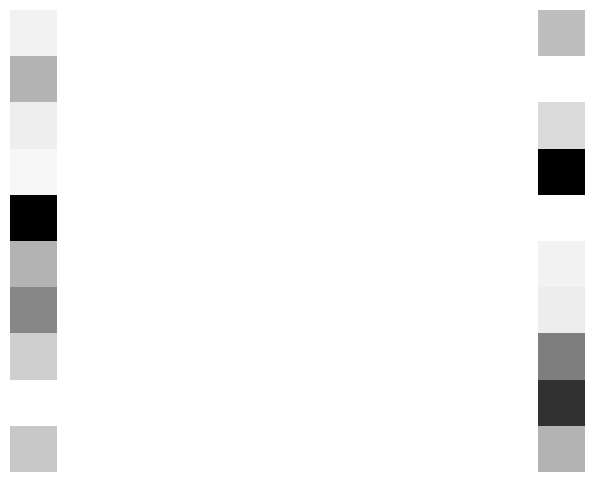

In [43]:
phi_2nd_layer = np.median(states['poisson_gamma_believe/~/gamma_layer']['phi'], axis=[0, 1])
# Make a plot of each latent state.
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12.5, 6))
for ax, phi in zip(axes.flatten(), phi_2nd_layer):
    ax.set_axis_off()
    image = phi.reshape(-1, 1)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

We can also analyse the effect of the second layer on the digits, through the first layer as: $\bm{\Phi}^{(2)} \bm{\Phi}^{(1)}$.

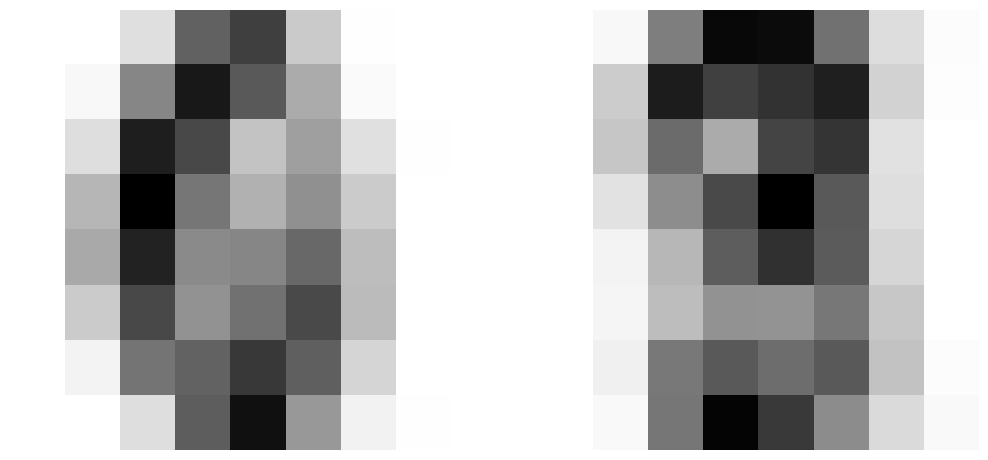

In [ ]:
phi_prod = states['poisson_gamma_believe/~/poisson_layer']['phi'][...,jnp.newaxis, :, :] * states['poisson_gamma_believe/~/gamma_layer']['phi'][...,jnp.newaxis]
phi_red = phi_prod.sum(axis=-2)
phi_projected = np.median(phi_red, axis=[0, 1])

# Make a plot of each latent state.
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12.5, 6))
for ax, phi in zip(axes.flatten(), phi_projected):
    ax.set_axis_off()
    image = phi.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")